In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

from helpers import *

%matplotlib inline

# **Step 1: Camera Calibration**

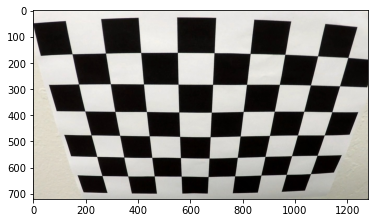

In [2]:
im = mpimg.imread('camera_cal/calibration2.jpg')
plt.imshow(im)

In [3]:
root = 'camera_cal/calibration'
nx, ny = 9, 6
ret, mtx, dist, rvecs, tvecs = calibrate(root, nx, ny)

Sanity Check:

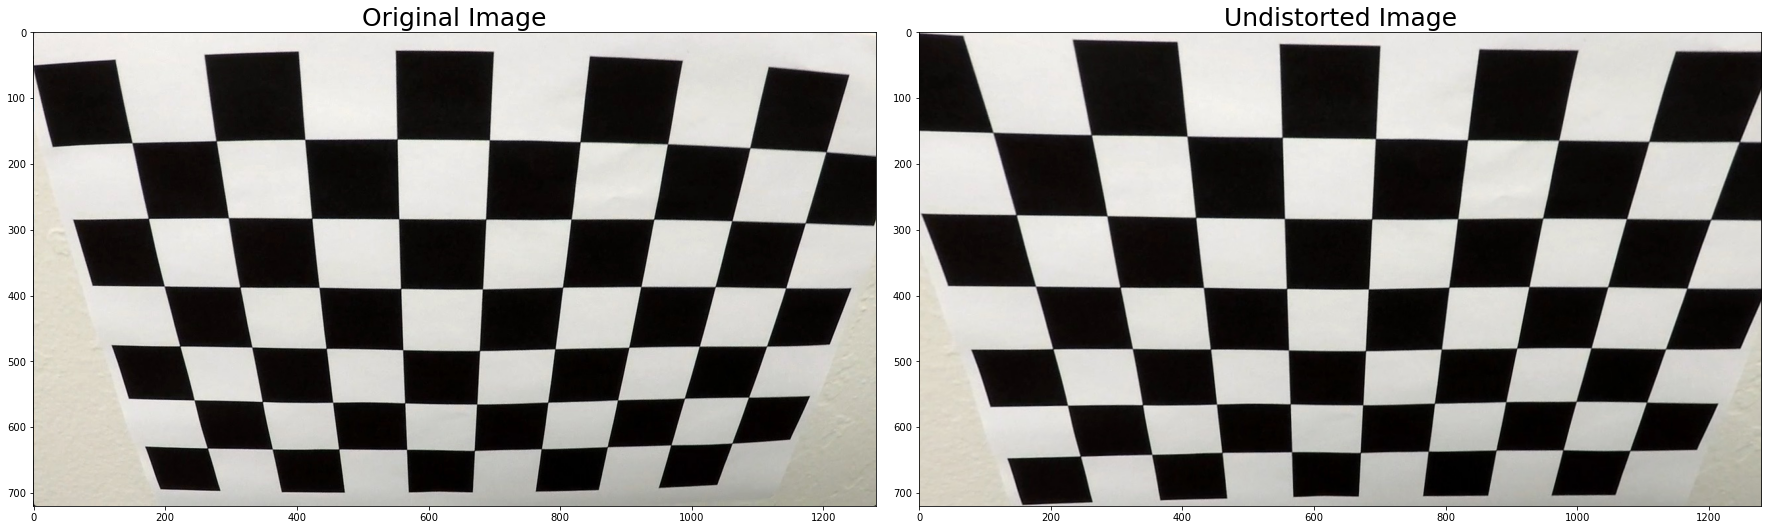

In [4]:
undistorted = undistort(im, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize = 25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize = 25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 2: Finding Edges in Images

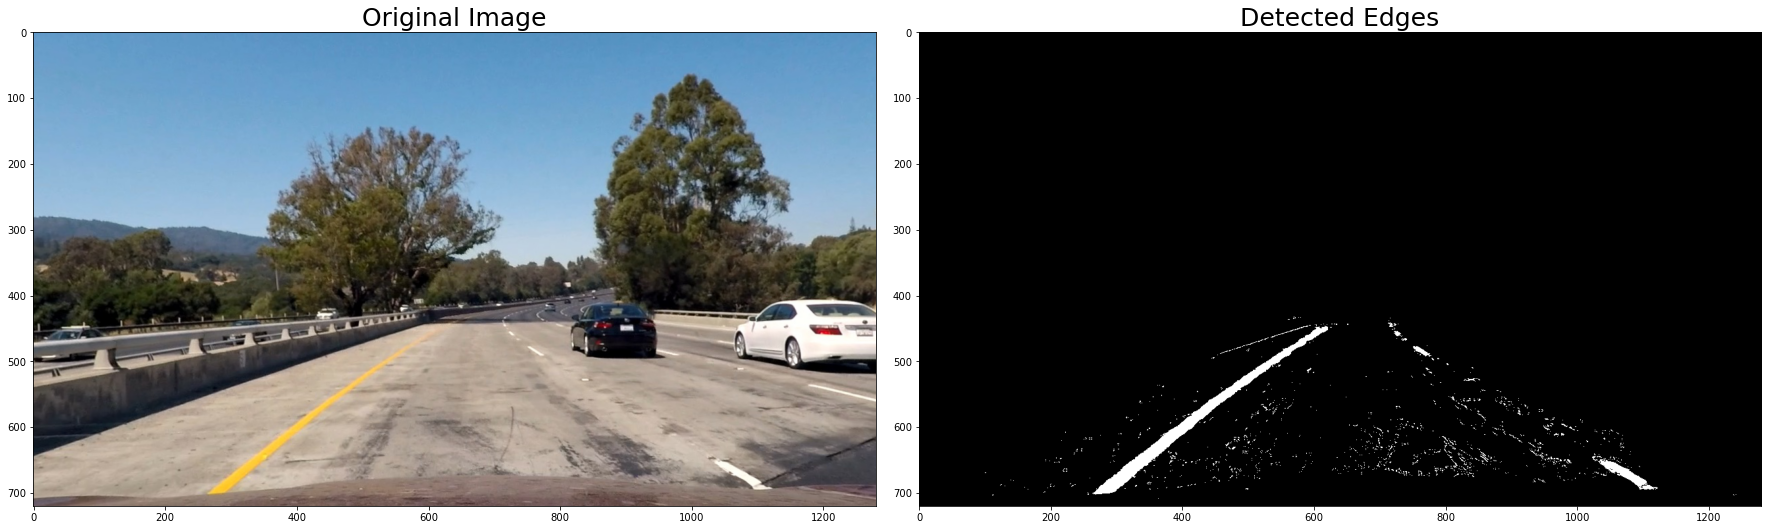

In [5]:
img = mpimg.imread('test_images/test1.jpg')
img = undistort(img, mtx, dist)

s_thresh=(150, 255)
sx_thresh=(20, 200)

edges = edge_pipeline(img)#, s_thresh, sx_thresh)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(edges, cmap='gray')
ax2.set_title('Detected Edges', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Part 3: Change Perspective

We want to warp our perspective to give a bird's eye view of the lane lines. This will enable accurately fitting a polynomial over them.

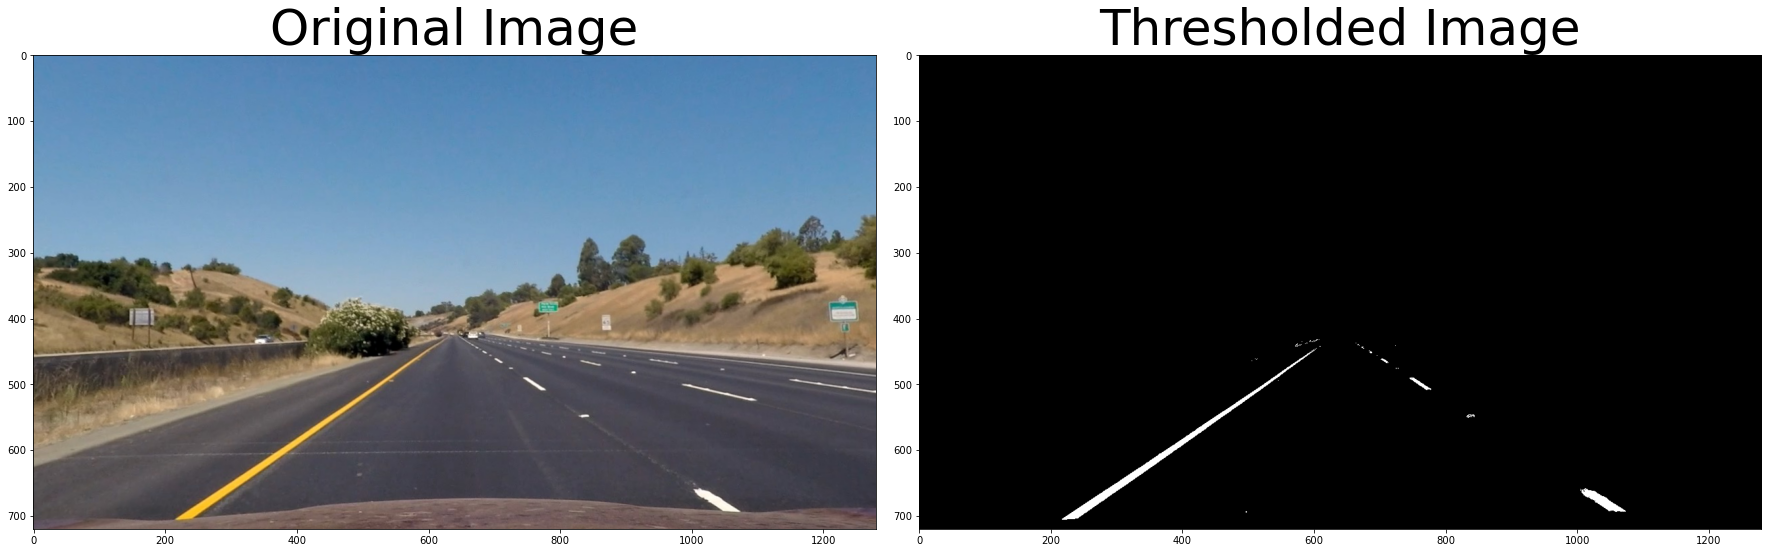

In [6]:
s_thresh=(150, 255)
sx_thresh=(20, 200)

img = mpimg.imread('test_images/straight_lines1.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
edges = edge_pipeline(img)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(edges, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

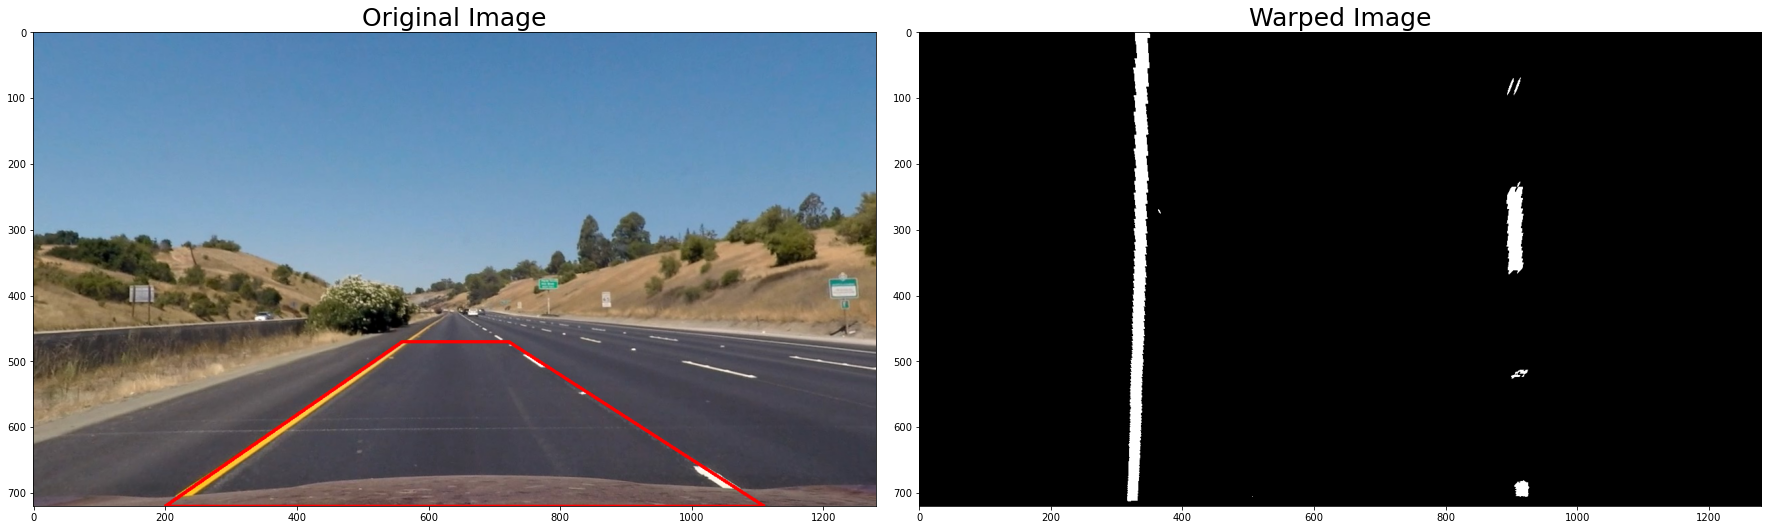

In [7]:
bottom_left = [200,720]
bottom_right = [1110, 720]
top_left = [560, 470]
top_right = [722, 470]
src = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts], True,(255,0,0), thickness=3)

bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [310, 0]
top_right = [920, 0]
dst = np.float32([bottom_left,bottom_right,top_right,top_left])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(edges, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Part 4: Lane Line Fitting

Below is an example of fitting a polynomial over pixels detected by sliding windows along the region with histogram spikes.

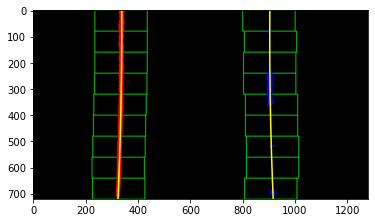

In [8]:
out_img, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(warped)
plt.imshow(out_img)

Below is an example of searching near the most recent fit for edges, and fitting a polynomial over those points.

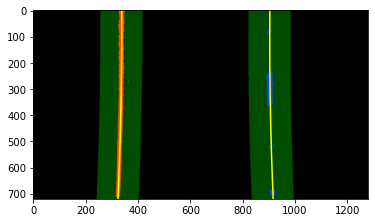

In [9]:
out_img, left_fit, right_fit, left_fitx, right_fitx = search_around_poly(warped, left_fit, right_fit, plot_fit=True)
plt.imshow(out_img)

## Part 5: Calculating Radius of Curvature, Center Offset and Creating Lane Overlay

In [10]:
left_rc = radius_of_curvature(left_fitx, out_img.shape[0])
right_rc = radius_of_curvature(right_fitx, out_img.shape[0])
average_rc = (left_rc + right_rc)/2
rc = "Radius of curvature: %.2f m" % average_rc
print(rc)

Radius of curvature: 4776.24 m


In [11]:
offset_string = offset((out_img.shape[1], out_img.shape[0]), left_fitx, right_fitx)
print(offset_string)

Vehicle is 0.11m right of center


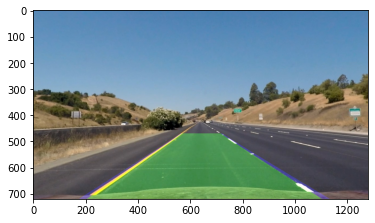

In [12]:
overlay = fill_lane(warped, img, left_fitx, right_fitx, M_inv)
plt.imshow(overlay)

## Part 6: Put It All Together for Videos

In [13]:
def pipeline(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global right_fit
    global left_fit
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_right_lines
    global past_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global mean_diff
    
    global mtx
    global M
    global M_inv
    global dist

    img_size = (img.shape[1], img.shape[0])
    
    edges = edge_pipeline(undistort(img, mtx, dist))#, (150, 255), (20, 200))
    warped = cv2.warpPerspective(edges, M, img_size, flags=cv2.INTER_LINEAR)
    
    num_rows = warped.shape[0]
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    if (left_fit is None) or (right_fit is None):
        # If the polynomial coefficients of the previous frames are None then find lines from scratch
        from_scratch = True
        out_img, left_fit, right_fit, left_fitx, right_fitx = fit_from_scratch(warped)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        from_scratch = False
        out_img, left_fit, right_fix, left_fitx, right_fitx = fit_with_previous(warped, left_fit, right_fit)
    
    if (left_fitx is None or right_fitx is None):
        if not from_scratch:
            out_img, left_fit, right_fit, left_fitx, right_fitx = fit_from_scratch(warped)
            
    bad_lines = False
            
    if (left_fitx is None or right_fitx is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_fitx - left_fitx)
        
        if mean_diff == 0:
            mean_diff = mean_difference
        
        if (mean_difference < 0.7*mean_diff or mean_difference > 1.3*mean_diff):
            bad_lines = True
            if not from_scratch:
                out_img, left_fit, right_fit, left_fitx, right_fitx = fit_from_scratch(warped)
                if (left_fitx is None or right_fitx is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_fitx - left_fitx)
                    if (mean_difference < 0.7*mean_diff or mean_difference > 1.3*mean_diff):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        left_fit = None
        right_fit = None
        if len(past_left_lines) == 0 and len(past_right_lines) == 0:
            return img
        else:
            left_fitx = past_left_lines[-1]
            right_fitx = past_right_lines[-1]
    else:
        past_left_lines, left_fitx = get_averaged_line(past_left_lines, left_fitx)
        past_right_lines, right_fitx = get_averaged_line(past_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        mean_diff = 0.9*mean_diff + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, ploty]))))
    
    # compute the radius of curvature
    left_rc = radius_of_curvature(left_fitx, out_img.shape[0])
    right_rc = radius_of_curvature(right_fitx, out_img.shape[0])
    average_rc = (left_rc + right_rc)/2
    rc = "Radius of curvature: %.2f m" % average_rc
    
    offset_ = offset(img_size, right_fitx, left_fitx)
    
    filled = fill_lane(warped, img, left_fitx, right_fitx, M_inv)
    
    cv2.putText(filled, rc, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(filled, offset_, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return filled


In [14]:
img = mpimg.imread('test_images/test5.jpg')

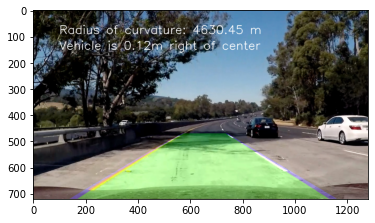

In [15]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
mean_diff = 0

filled = pipeline(img)
plt.imshow(filled)

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
mean_diff = 0

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

t:   0%|          | 2/1260 [00:00<01:35, 13.21it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 7min 51s, sys: 1min 3s, total: 8min 54s
Wall time: 2min 59s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [21]:
left_fit = None
right_fit = None
past_left_lines = []
past_right_lines = []
mean_diff = 0


output = 'challenge_video_output1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

t:   0%|          | 2/485 [00:00<00:32, 14.72it/s, now=None]

Moviepy - Building video challenge_video_output1.mp4.
Moviepy - Writing video challenge_video_output1.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output1.mp4
CPU times: user 1min 33s, sys: 16.2 s, total: 1min 49s
Wall time: 1min


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))